In [2]:
%run './model/multi_corpus.py'
%run './constants.py'


# Temporal Louvain Community Number

In [3]:
temporal_dfs_path = os.path.join(OUTPUT_PATH, 'temporal_dfs')
data = []
field_names = []
for file_name in os.listdir(temporal_dfs_path):
    field_name = file_name.split('.parquet')[0]
    df = pl.read_parquet(os.path.join(temporal_dfs_path, file_name))
    field_names.append(field_name)
    data.append((df['Year'], df['CumDoi']))

Gender Studies


/var/folders/rz/n4jmlyh1355cy_wkn5gd00x40000gn/T/ipykernel_825/2525172010.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Geometry
Geophysics
Economics
Language & Linguistics
Probability & Statistics
Material Engineering
Artificial Intelligence
Sociology
International Business
Political Science
Genetics & Genomics
Immunology
Human Resources & Organizations
Ethnic & Cultural Studies
Neurology


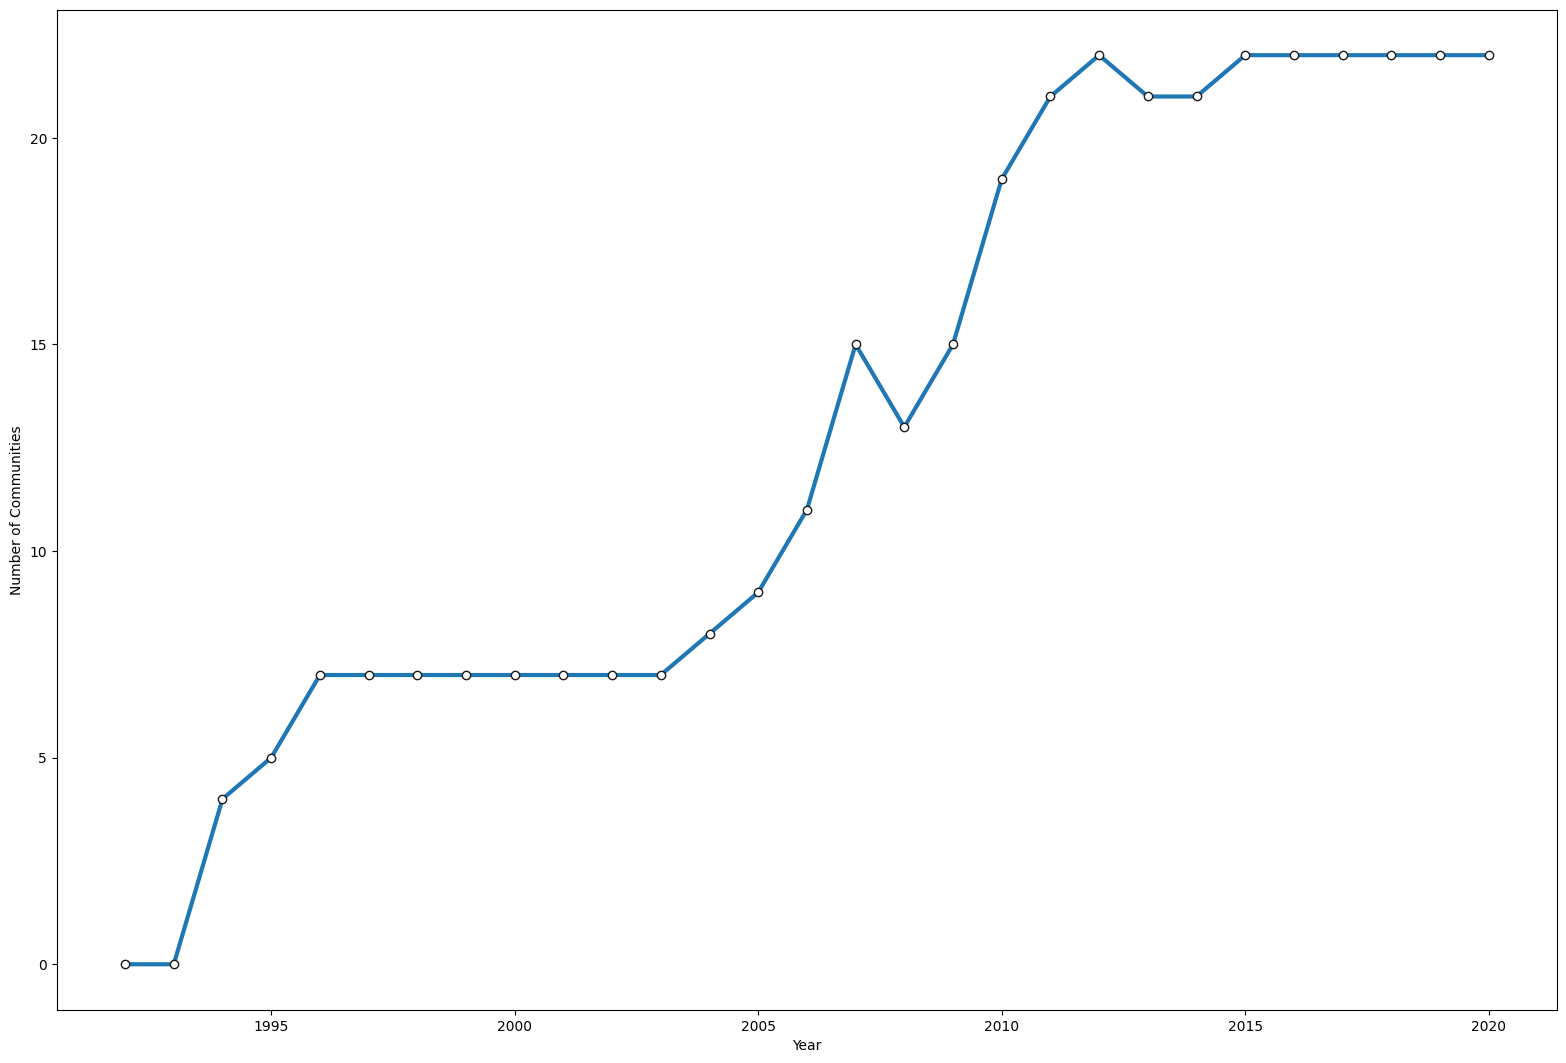

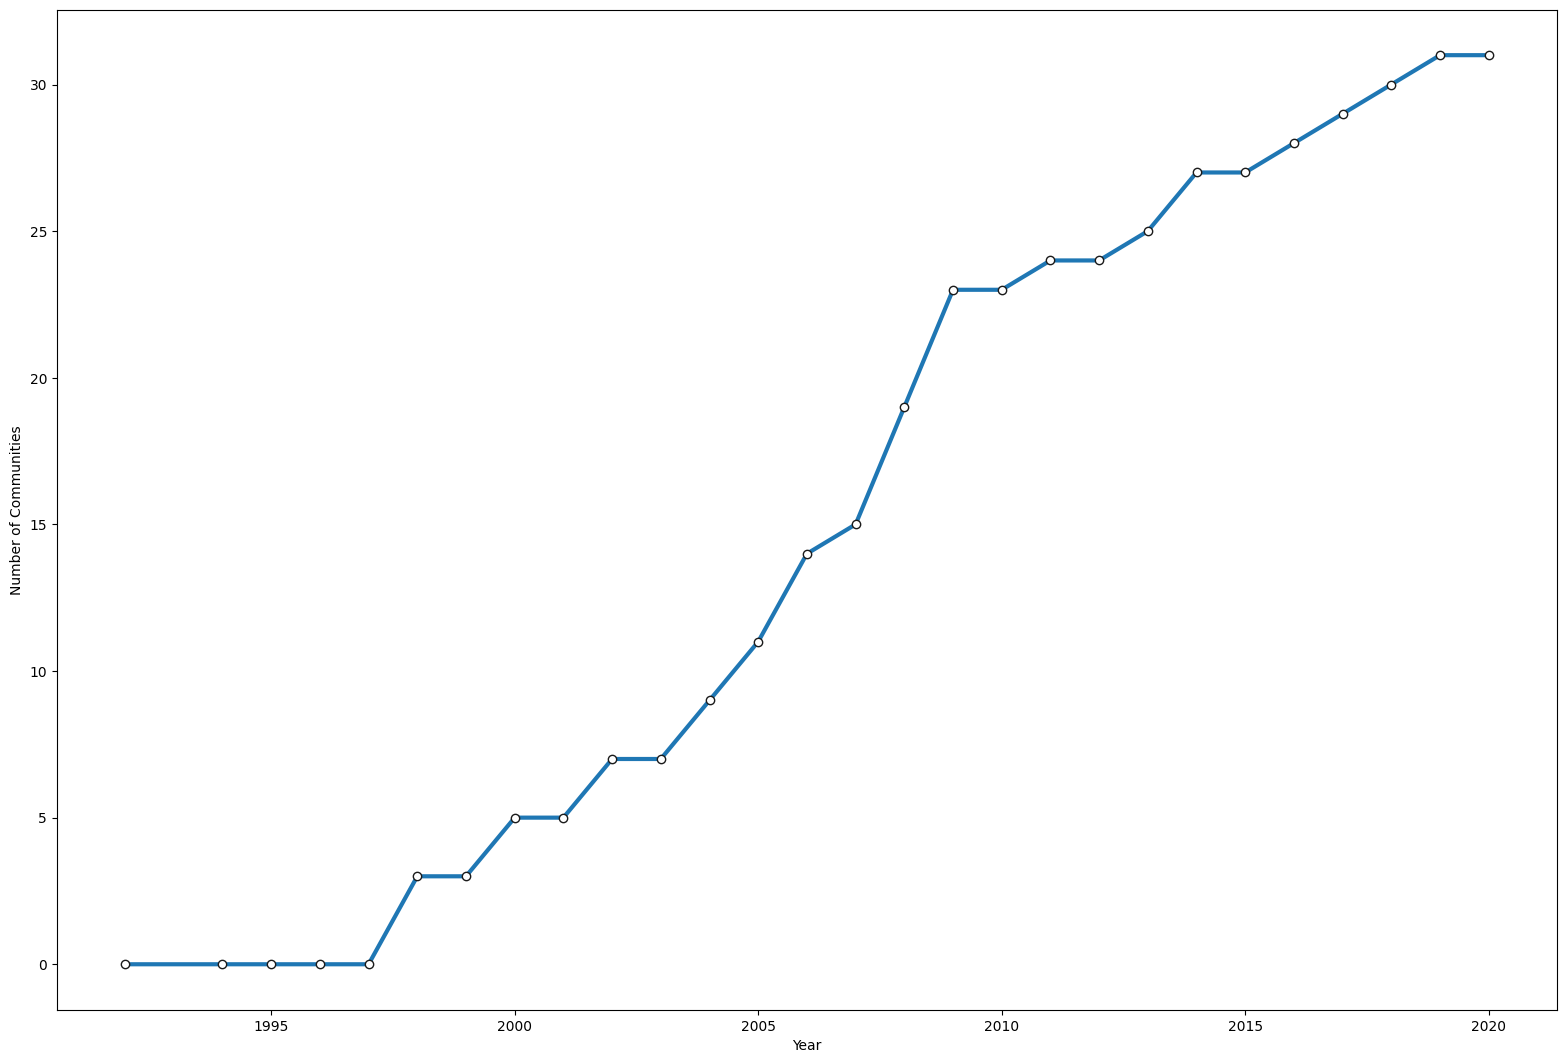

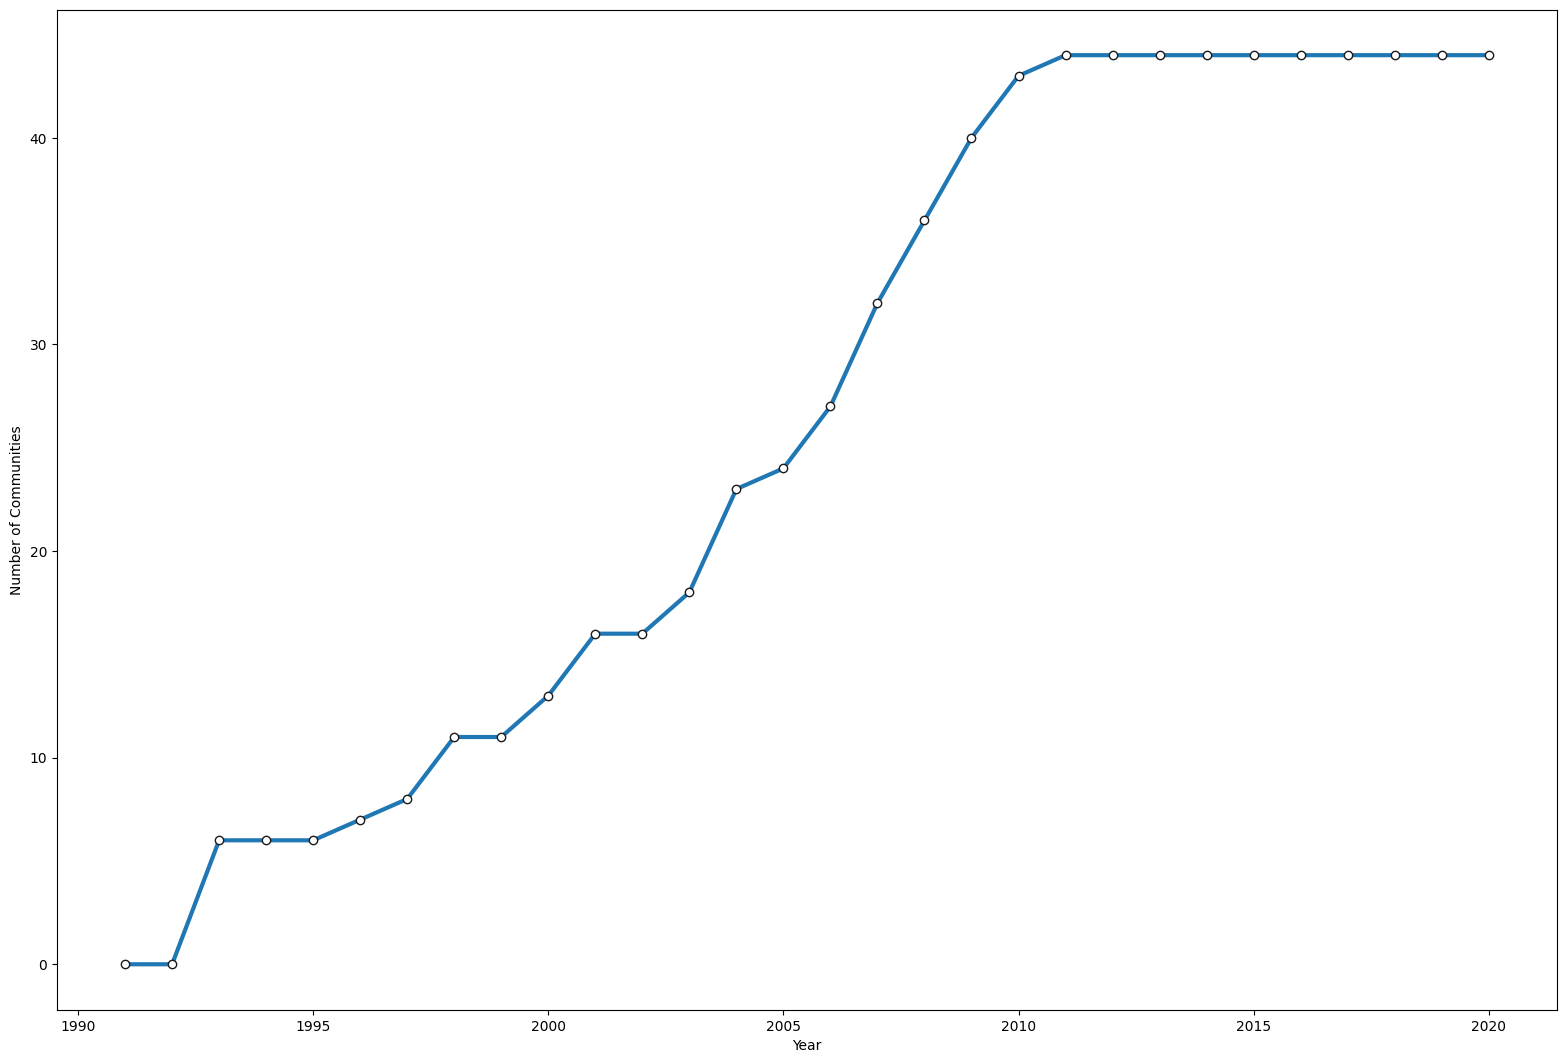

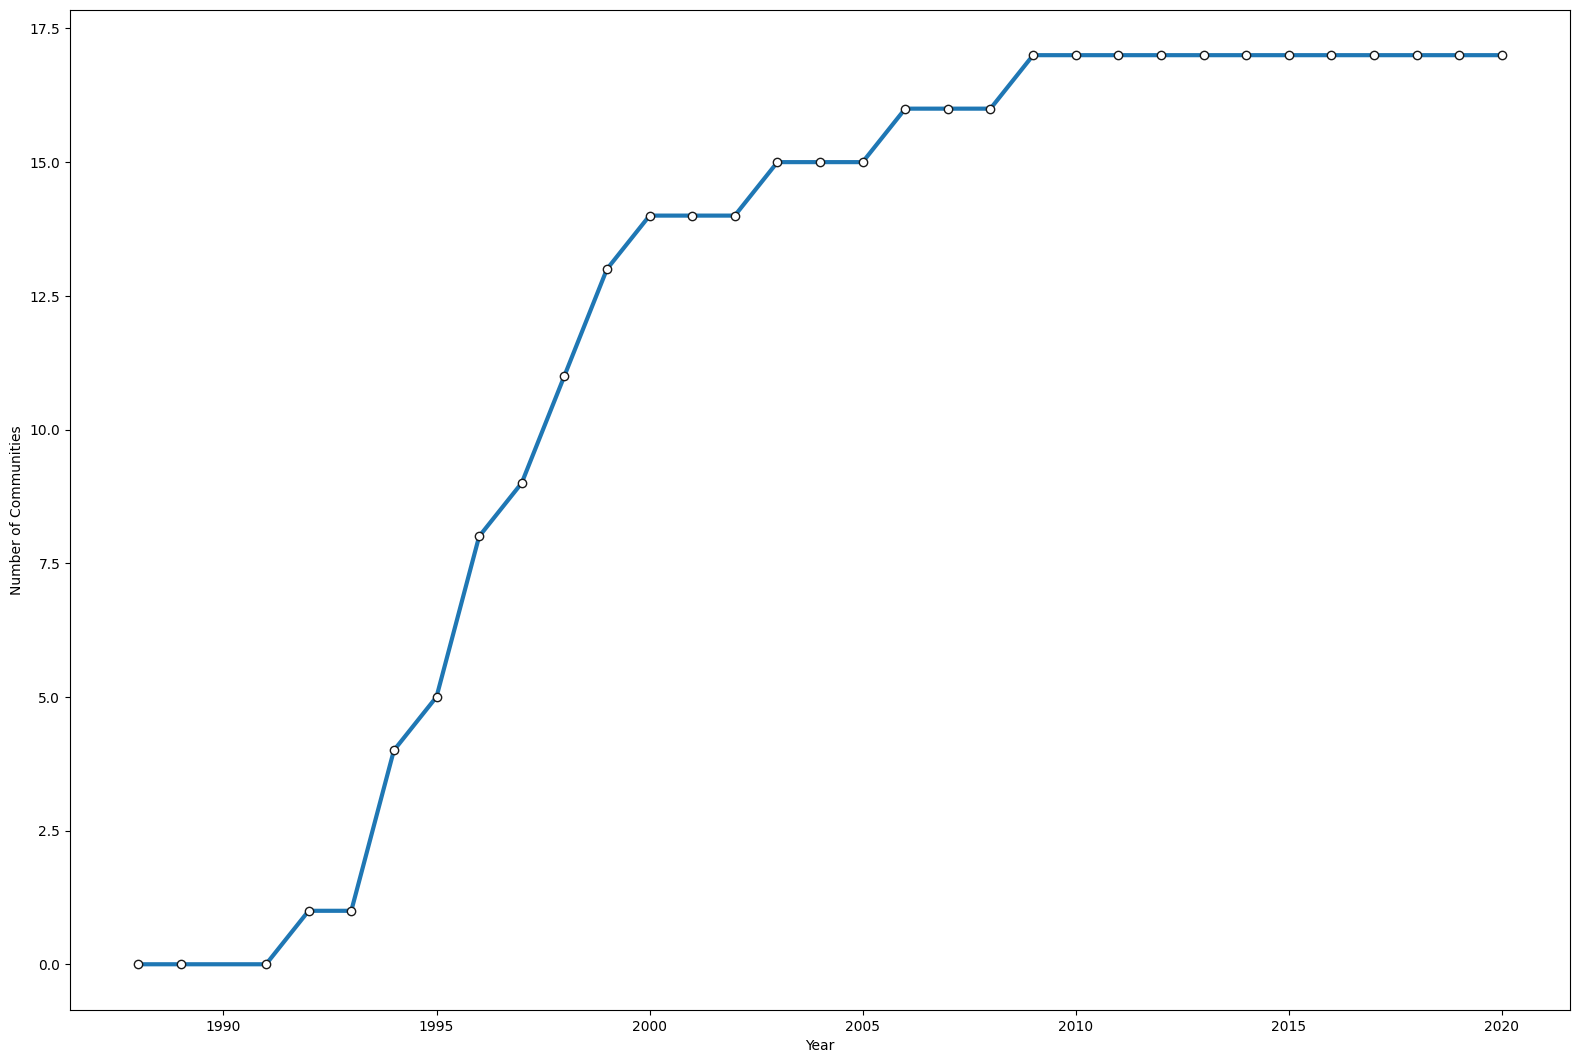

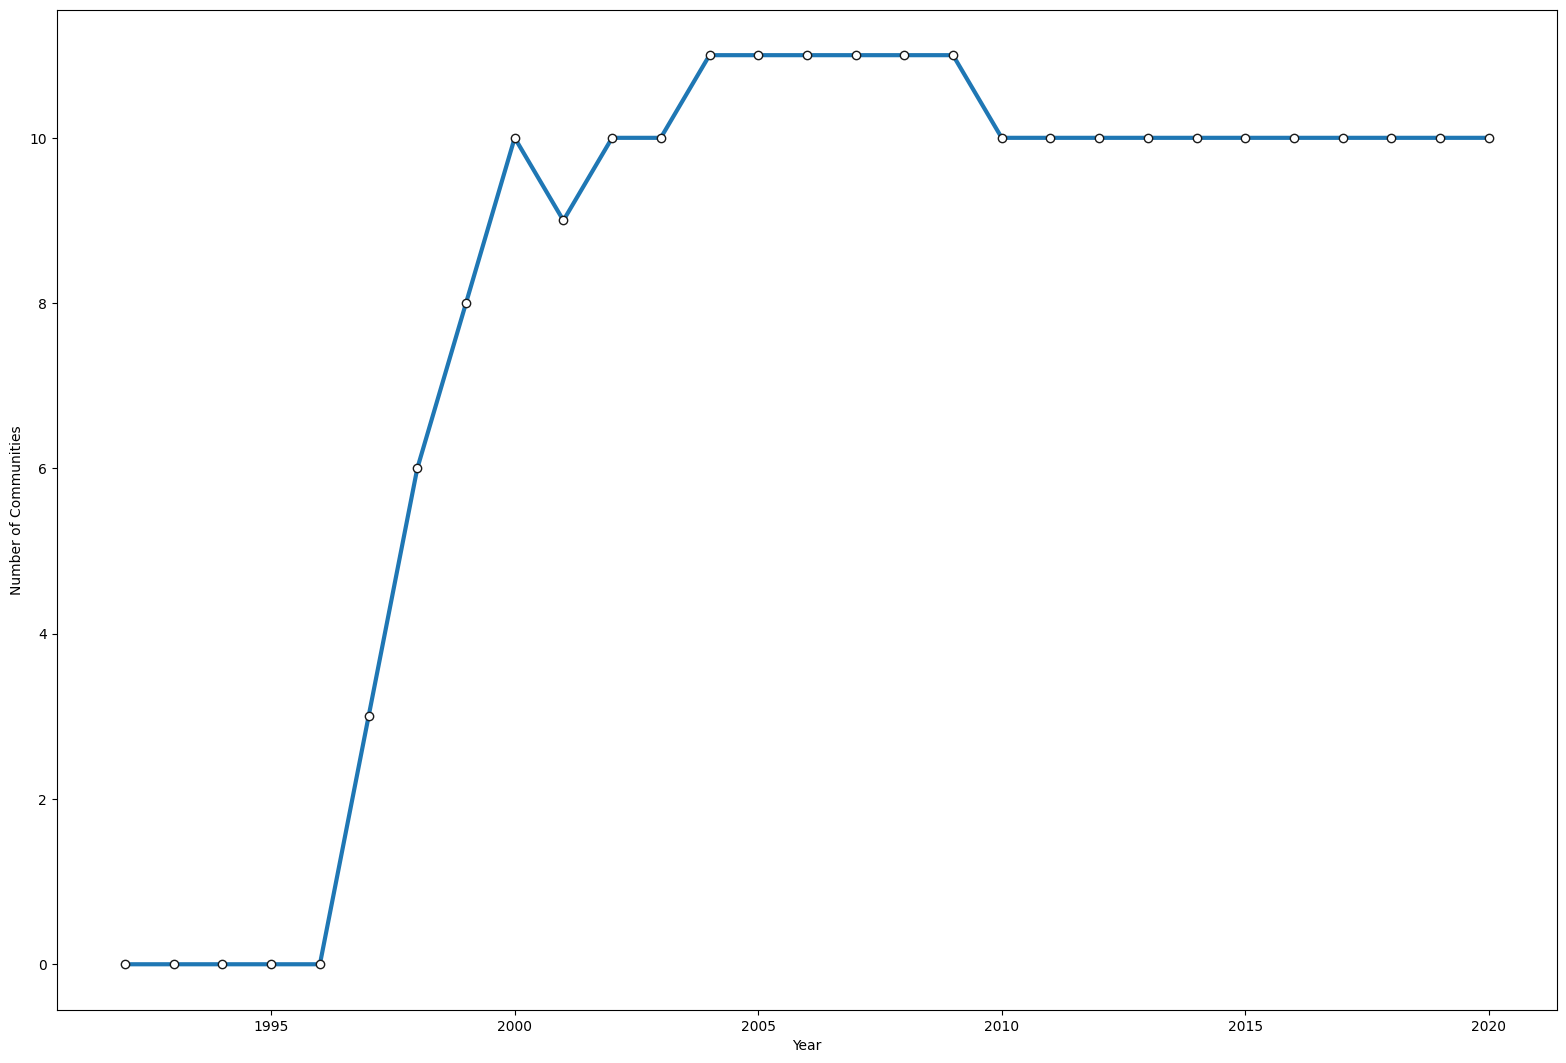

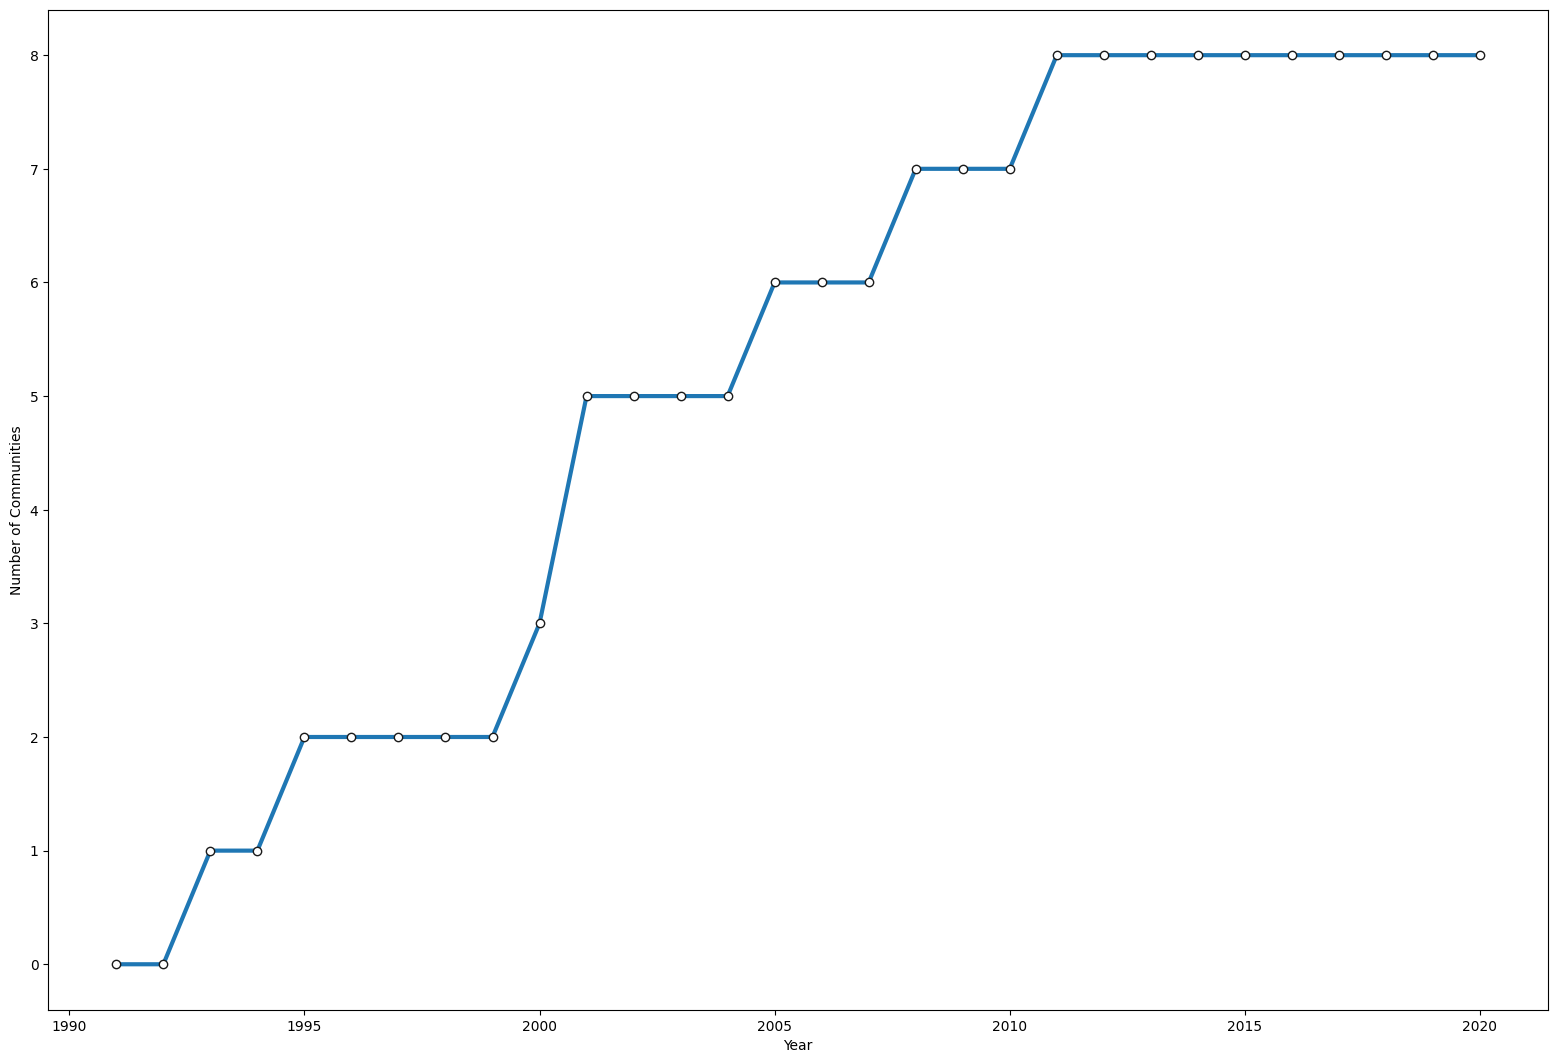

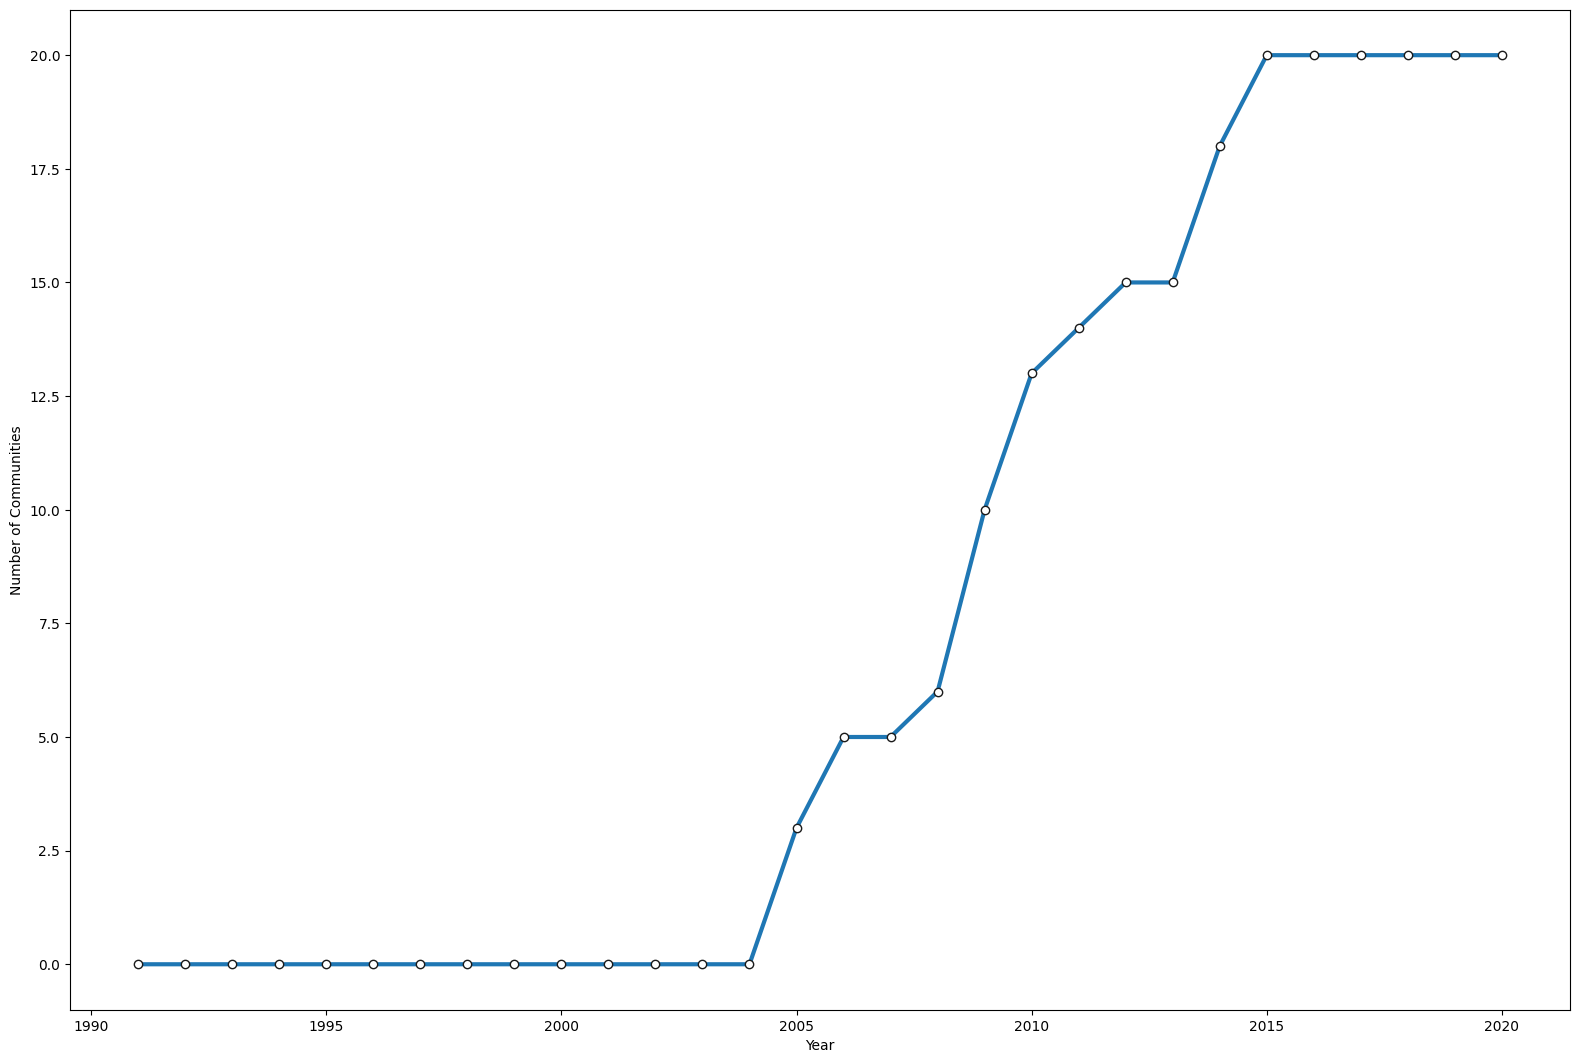

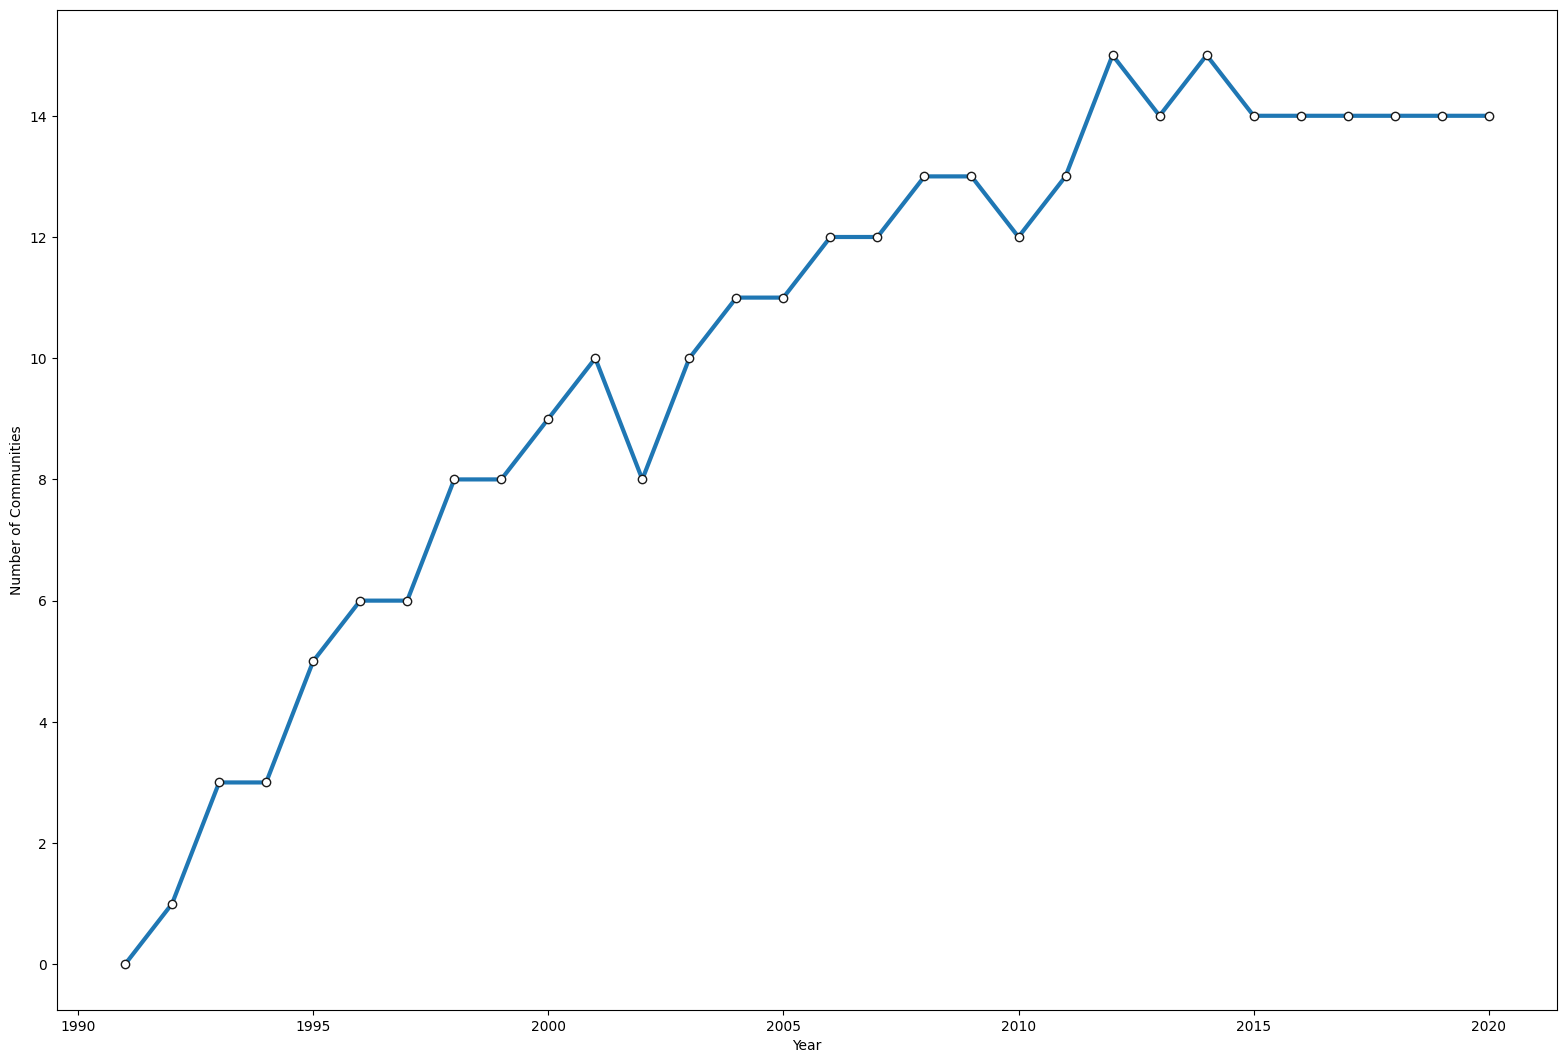

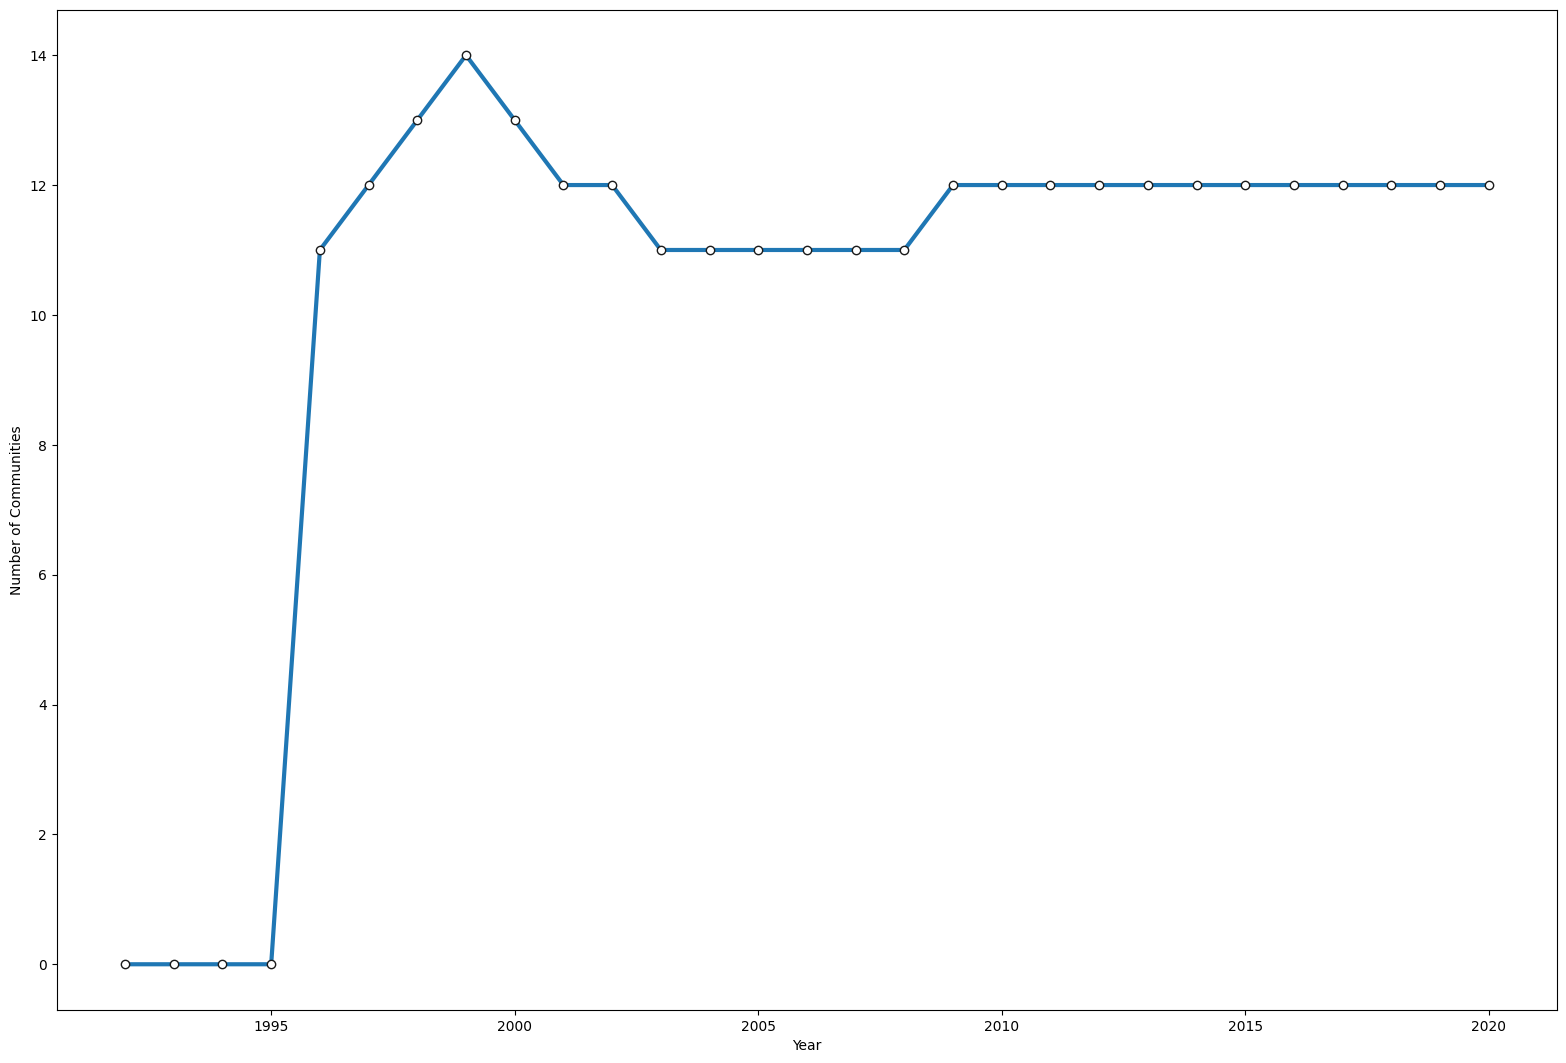

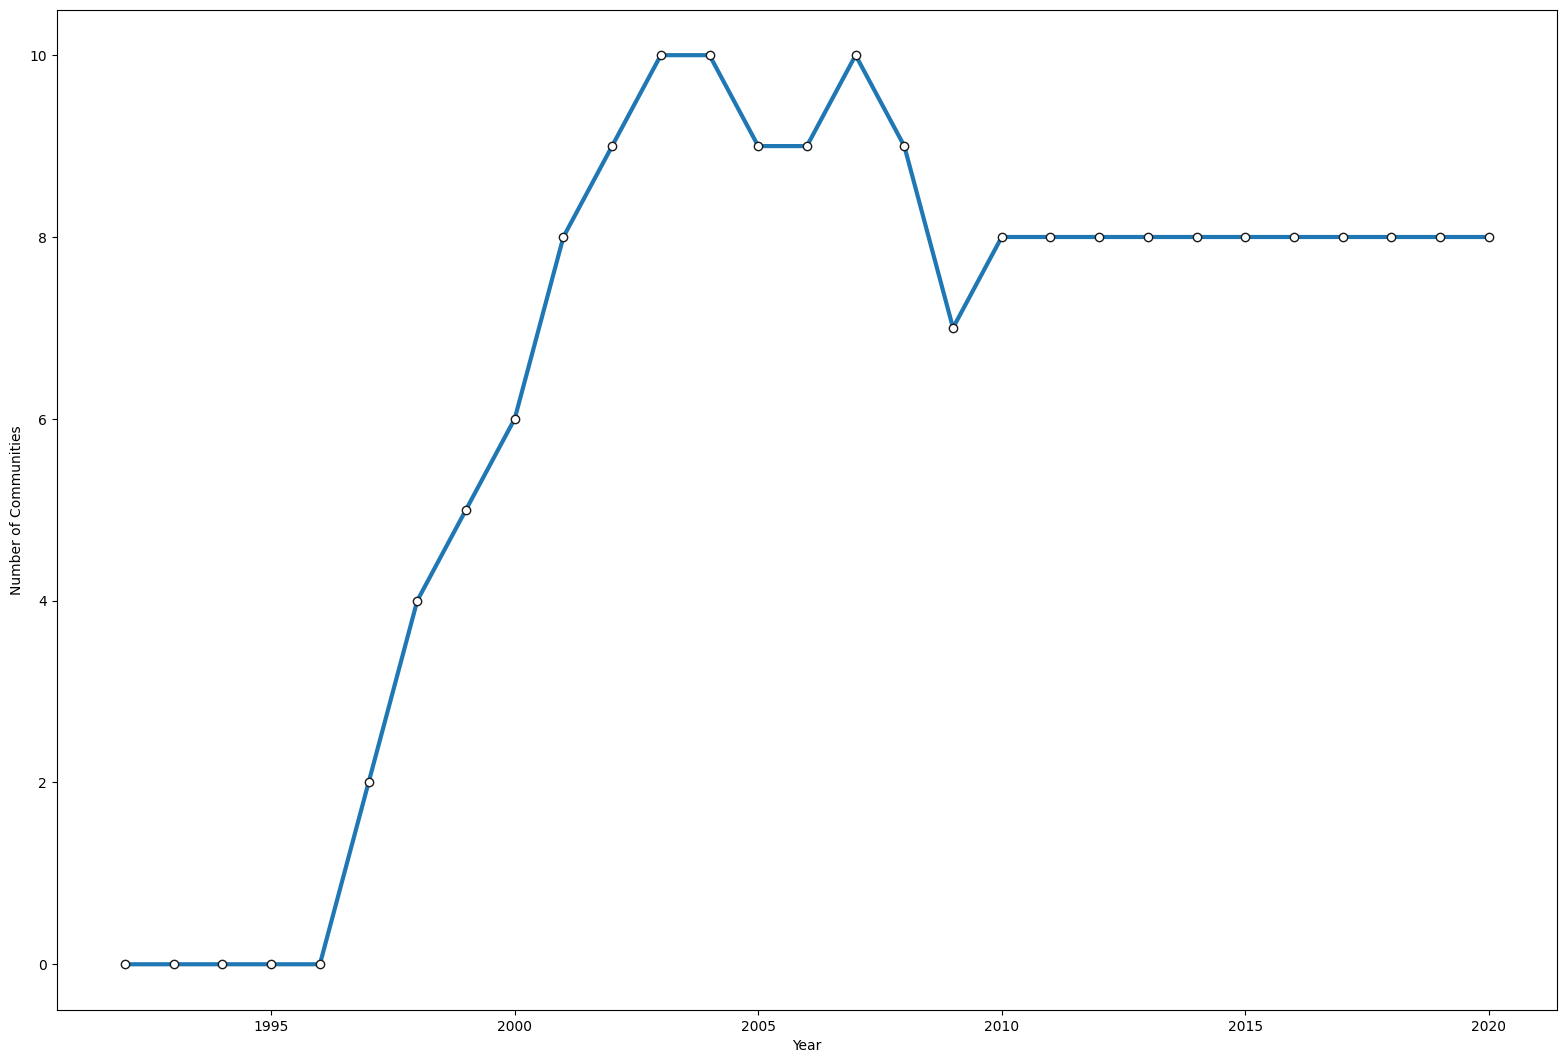

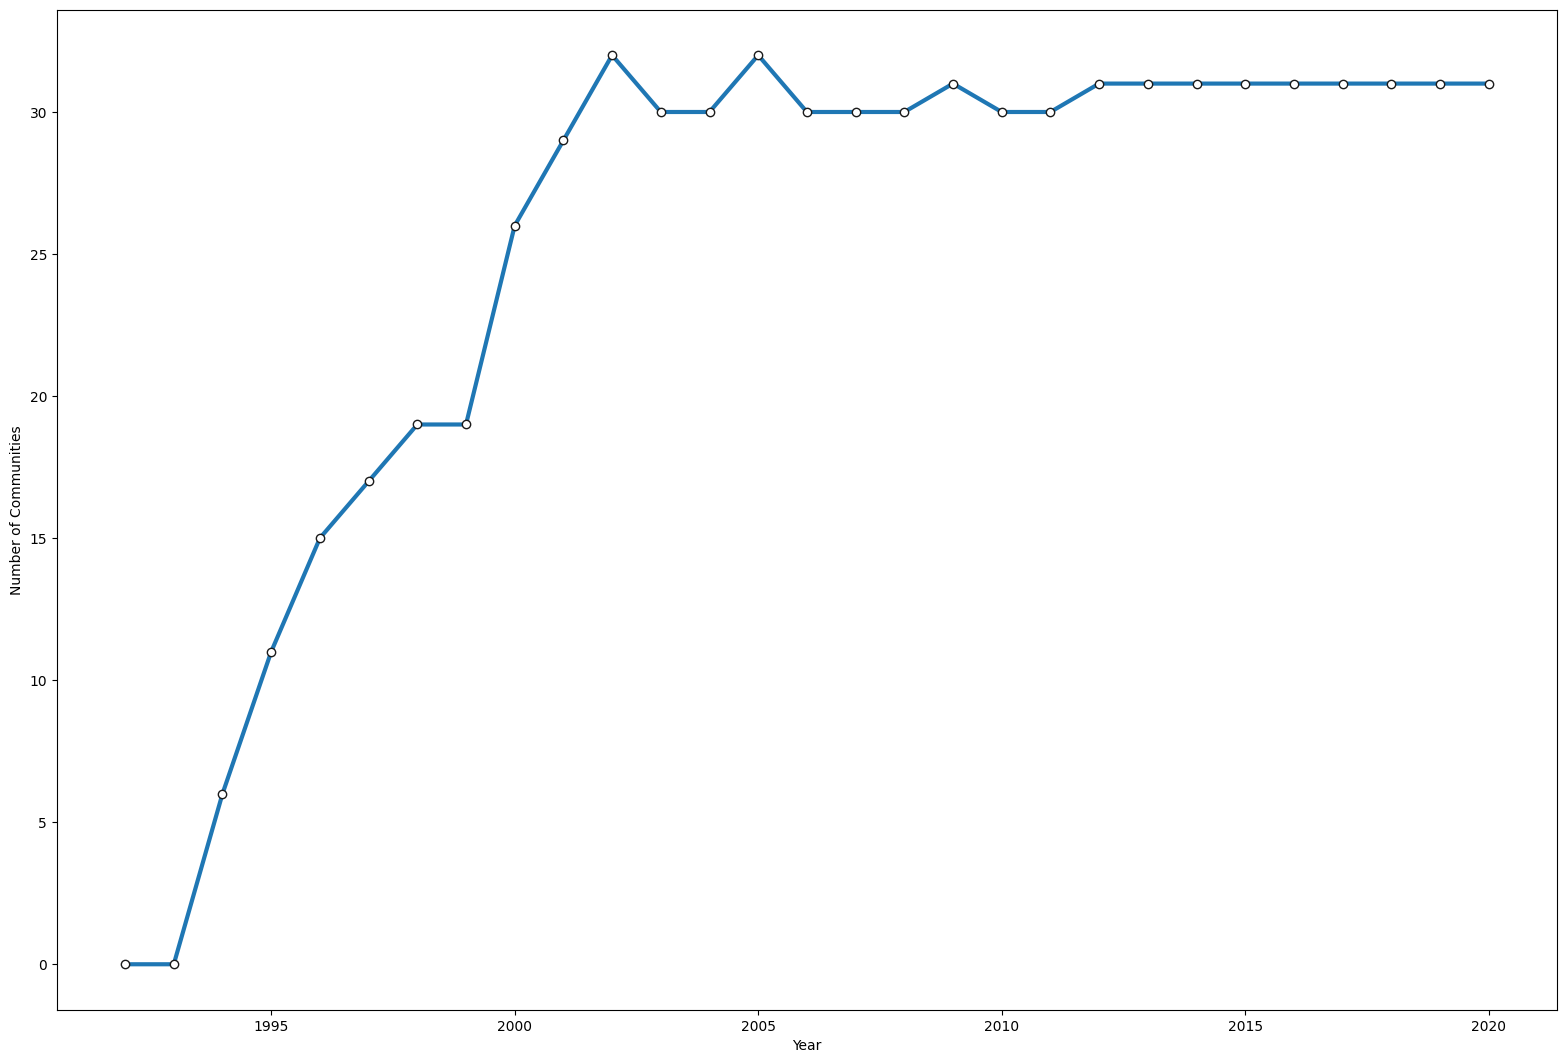

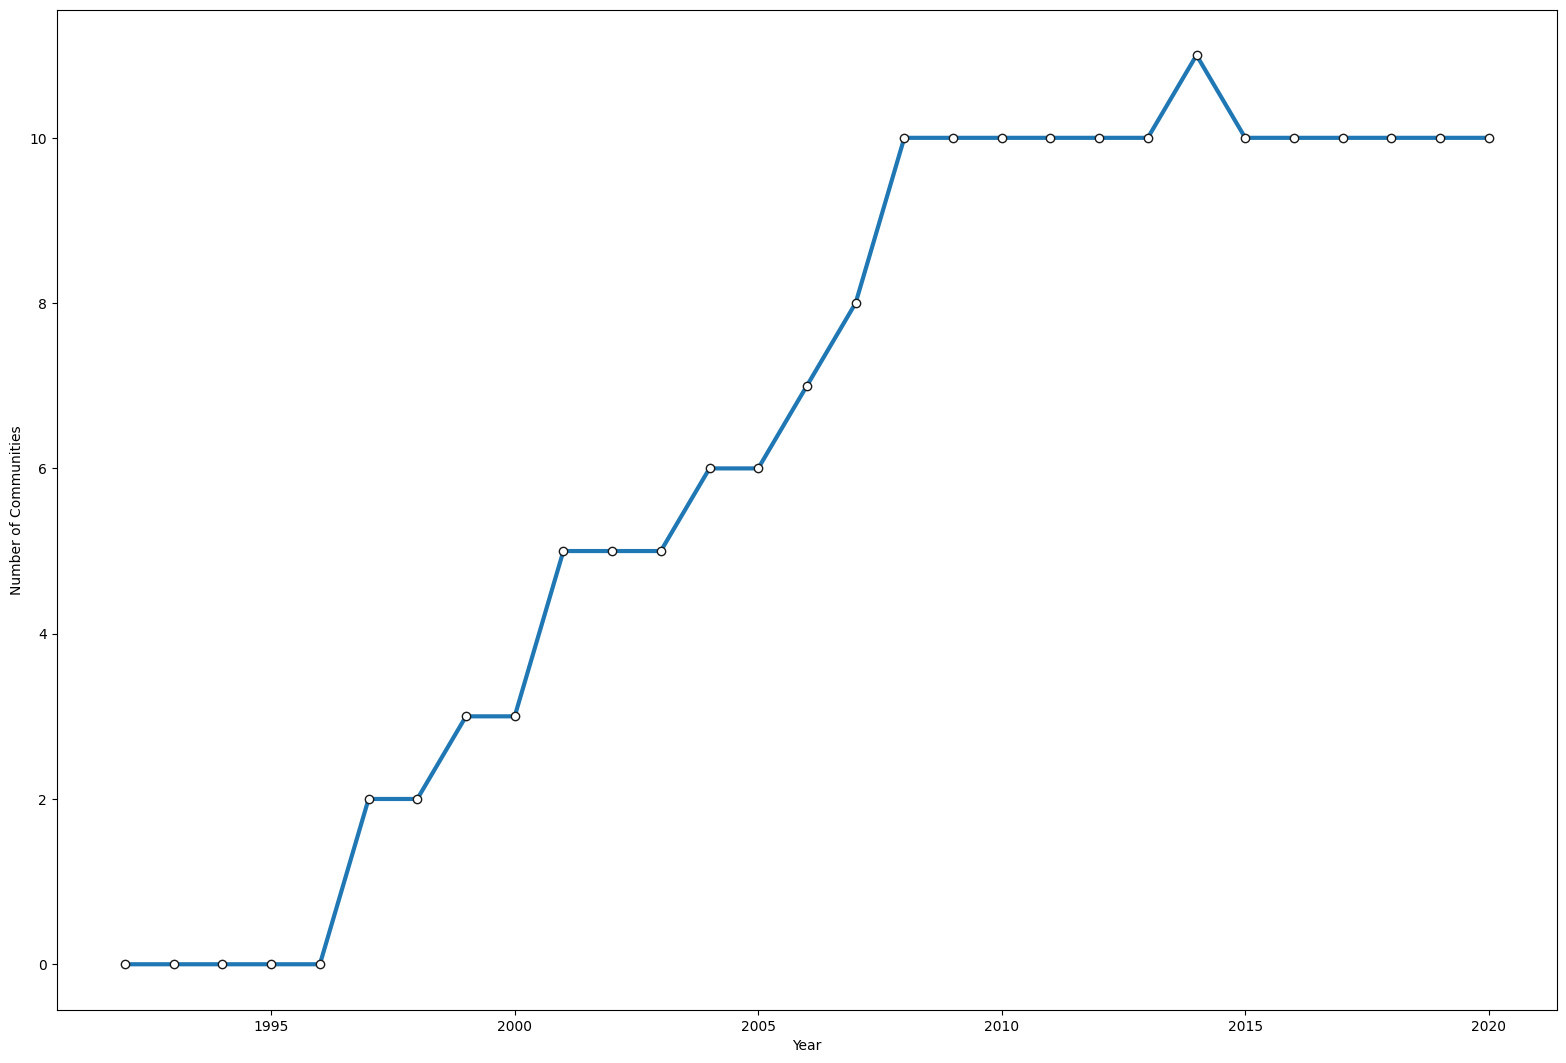

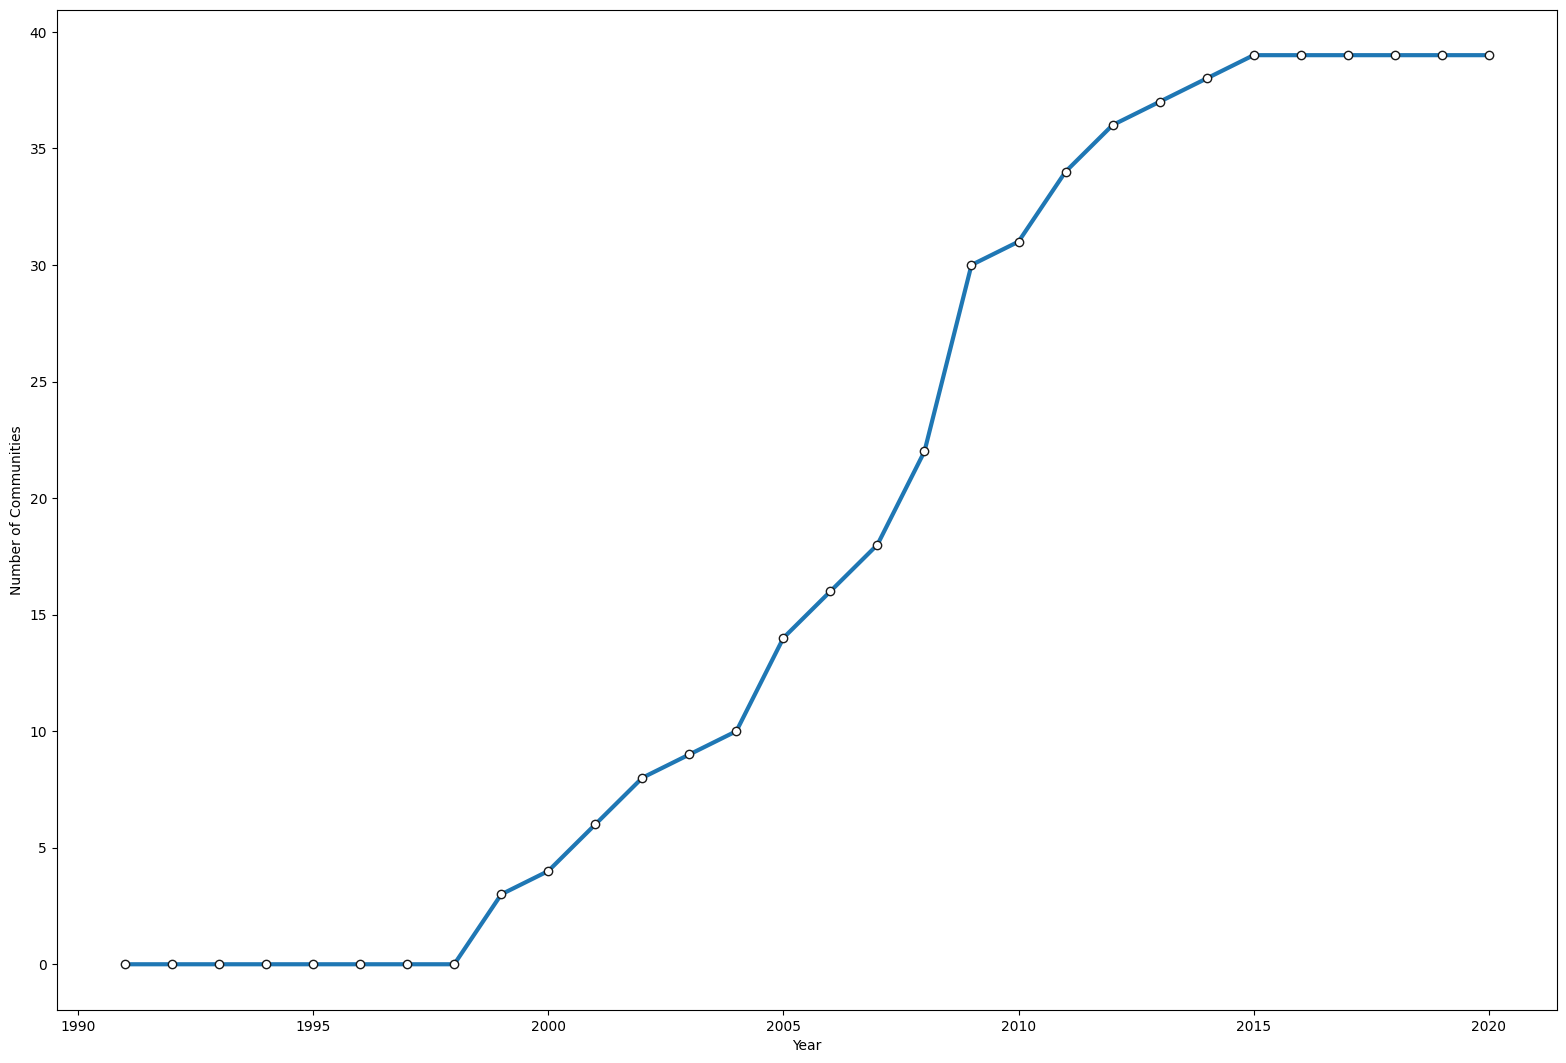

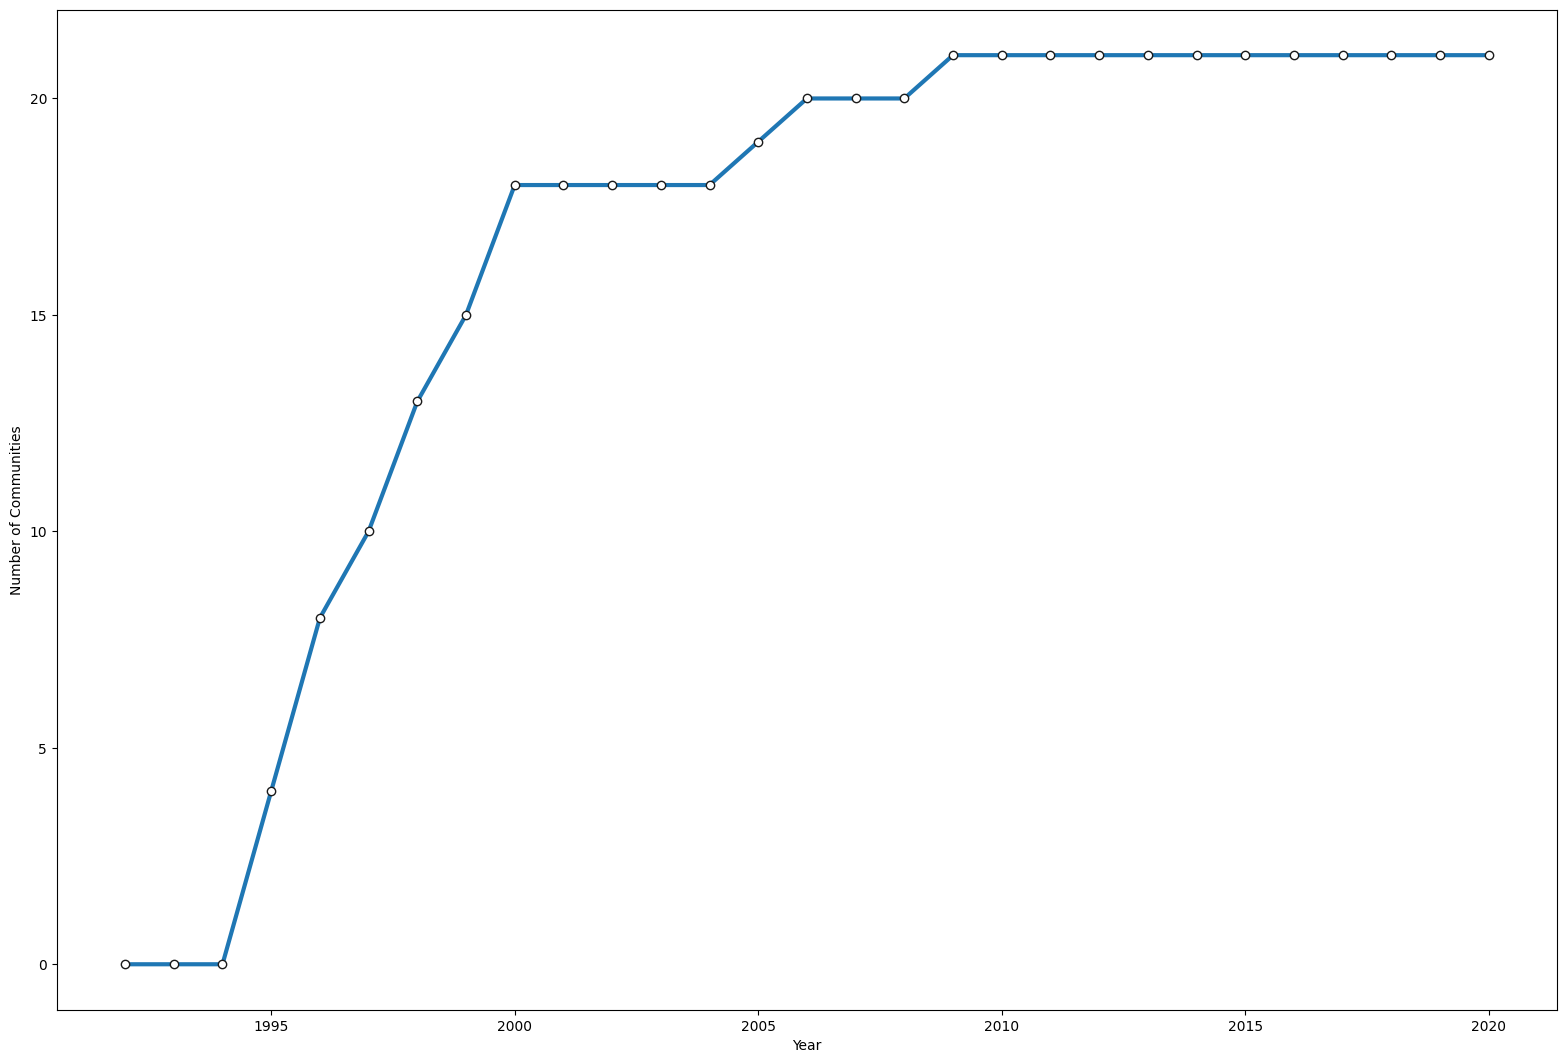

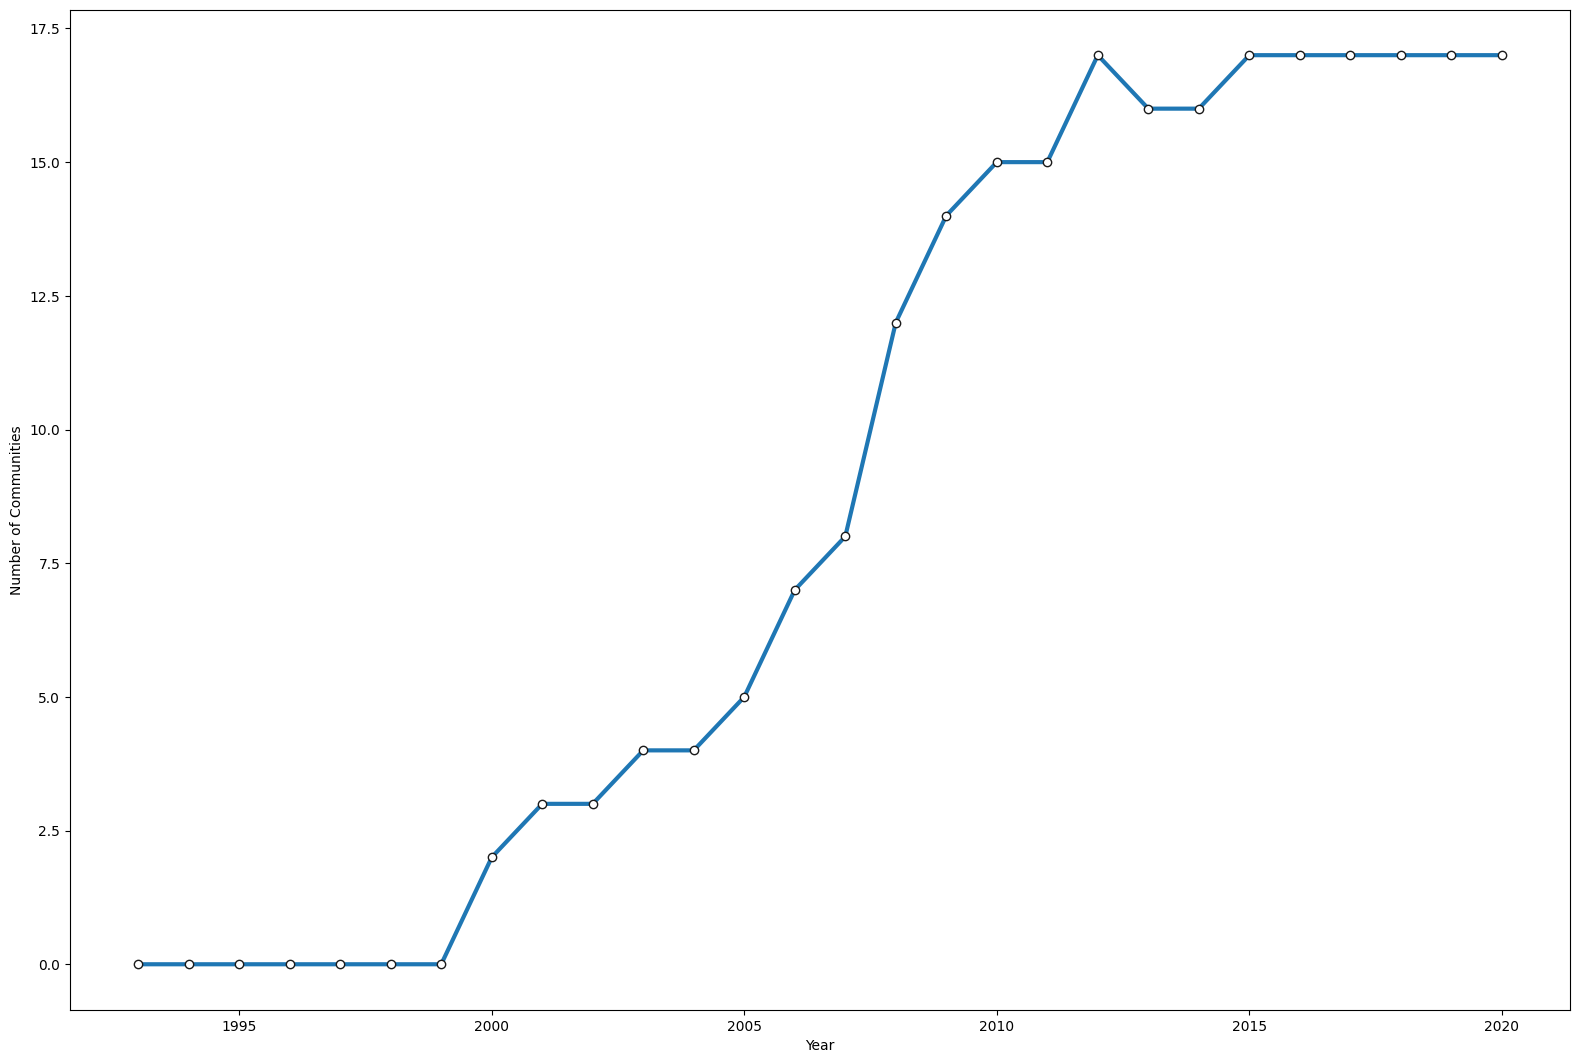

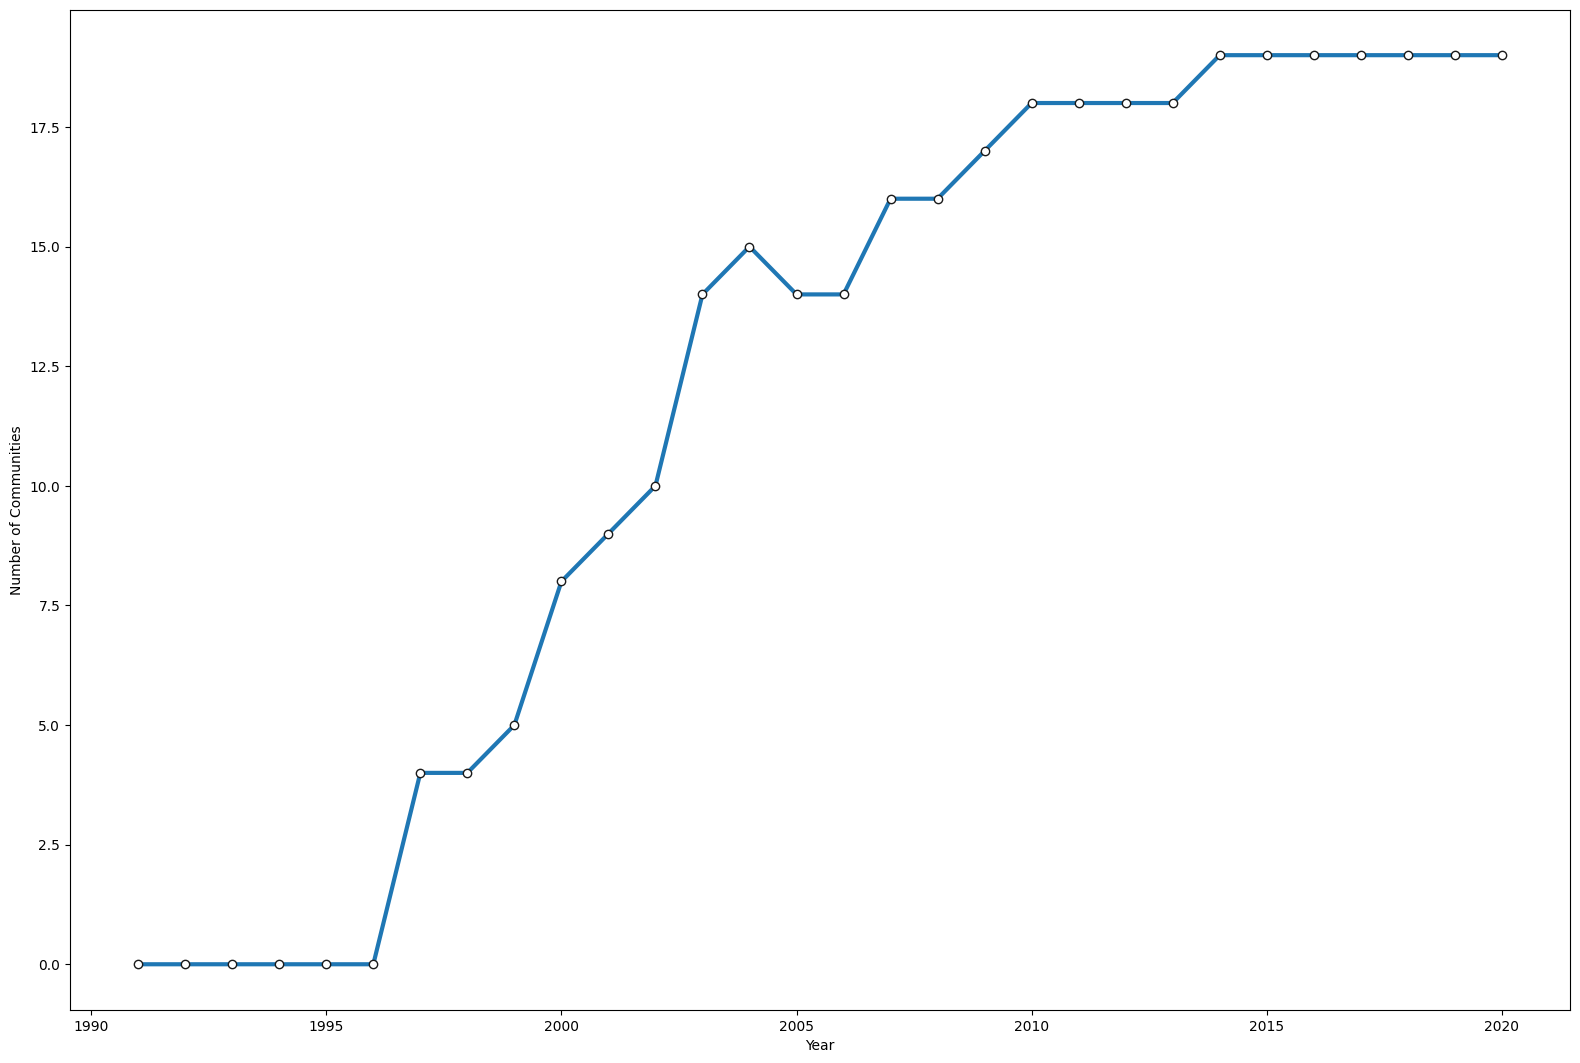

In [15]:
sns.reset_defaults()

for field_name, (years, dois) in zip(field_names, data):

    print(field_name)

    df = pl.read_csv(os.path.join(OUTPUT_PATH, 'co_citation_graphs', field_name + '.edgelist'), sep=' ', has_header=False)
    G = nx.from_pandas_edgelist(df, create_using=nx.Graph, source='column_1', target='column_2')

    louvain_comms = {}
    for year, doi in zip(years, dois):
        G_sub = G.subgraph(doi.to_list())
        if nx.is_empty(G_sub):
            louvain_comms[year] = 0   
            continue 
        comms = nx.community.louvain_communities(G_sub, seed=123)
        louvain_comms[year] = len(comms)

    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_axes([0, 0, 1, 1])

    years = louvain_comms.keys()
    louvain_comms = louvain_comms.values()

    ax.plot(years, louvain_comms, 'o-', markeredgecolor='k', markerfacecolor="white", linewidth=3)
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Communities')

    ax.grid(False)

    fig.tight_layout()

    plt.savefig(
        os.path.join(LATEX_FIGURES_PATH, 'co_citation_temporal_louvain_comms', f'{field_name.capitalize()}.png'), 
        transparent=True, 
        dpi=200,
        bbox_inches='tight'
    )
